In [107]:
# !pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [108]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets
df = pd.concat([X,y], axis=1)
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [109]:
wine_quality.metadata, wine_quality.variables, X.describe()

({'uci_id': 186,
  'name': 'Wine Quality',
  'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality',
  'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv',
  'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).',
  'area': 'Business',
  'tasks': ['Classification', 'Regression'],
  'characteristics': ['Multivariate'],
  'num_instances': 4898,
  'num_features': 11,
  'feature_types': ['Real'],
  'demographics': [],
  'target_col': ['quality'],
  'index_col': None,
  'has_missing_values': 'no',
  'missing_values_symbol': None,
  'year_of_dataset_creation': 2009,
  'last_updated': 'Wed Nov 15 2023',
  'dataset_doi': '10.24432/C56S3T',
  'creators': ['Paulo Cortez',
   'A. Cerdeira',
   'F. Almeida',
   'T. Matos',
   'J. Reis'],
  'intro_paper': {'ID': 252,


In [110]:
print(f'Número de observações (N): {X.shape[0]}.')
print(f'Número de preditores (D): {X.shape[1]}.')
print('Variável alvo (Y):', wine_quality.metadata['target_col'])

Número de observações (N): 6497.
Número de preditores (D): 11.
Variável alvo (Y): ['quality']


In [111]:
num_cols = [col for col in X.columns]
# fig, axes = plt.subplots(4, 3, figsize=(15,15))
# axes = axes.flatten()

# for i, col in enumerate(num_cols):
#     sns.histplot(X[col], kde=True, ax=axes[i])
#     axes[i].set_title(f'Distribuição de {col}')
# plt.tight_layout()

In [112]:
skew_values = X[num_cols].apply(lambda x: skew(x.dropna()))
print(skew_values)

fixed_acidity           1.722892
volatile_acidity        1.494751
citric_acid             0.471622
residual_sugar          1.435073
chlorides               5.398581
free_sulfur_dioxide     1.219784
total_sulfur_dioxide   -0.001177
density                 0.503485
pH                      0.386749
sulphates               1.796855
alcohol                 0.565587
dtype: float64


In [113]:
#Yeo and Johnson transformation

features_with_zeros = [column for column in X.columns if (X[column] == 0).any()]

X_transformed = X.copy()

for col in X.columns:
    if abs(skew_values[col])>0.5:
        X_transformed[col] = np.log1p(X_transformed[col]) if col in features_with_zeros else np.log(X_transformed[col])

In [114]:
skew_values_transformed = X_transformed[num_cols].apply(lambda x: skew(x.dropna()))
print(skew_values_transformed)

fixed_acidity           0.888932
volatile_acidity        0.327723
citric_acid             0.471622
residual_sugar          0.240636
chlorides               0.876270
free_sulfur_dioxide    -0.834005
total_sulfur_dioxide   -0.001177
density                 0.467260
pH                      0.386749
sulphates               0.404899
alcohol                 0.381772
dtype: float64


In [115]:
num_cols_transformed = [col for col in X_transformed.columns]

# fig, axes = plt.subplots(4, 3, figsize=(15,15))
# axes = axes.flatten()

# for i, col in enumerate(num_cols_transformed):
#     sns.histplot(X_transformed[col], kde=True, ax=axes[i])
#     # axes[i].set_title(f'Distribuição de {col}')
# fig.suptitle("Distribution after Yeo and Johnson transformation", fontsize=15)
# fig.tight_layout()

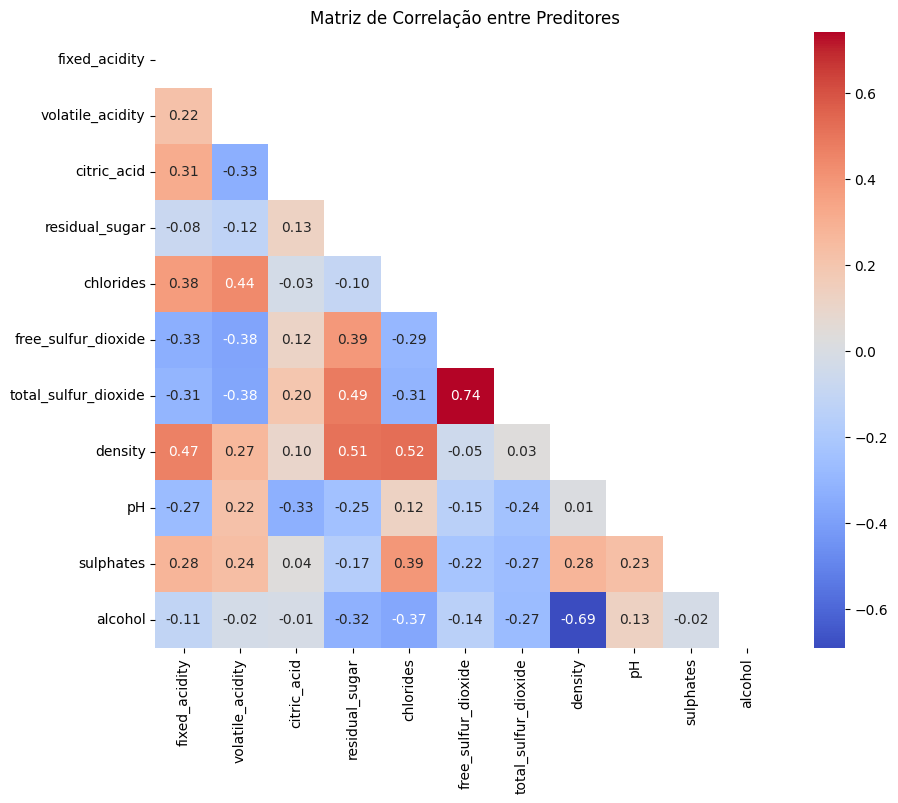

In [116]:
# Se quisermos a matriz de correlação depois de transformada
corr_matrix = X_transformed[num_cols_transformed].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Matriz de Correlação entre Preditores')
plt.show()

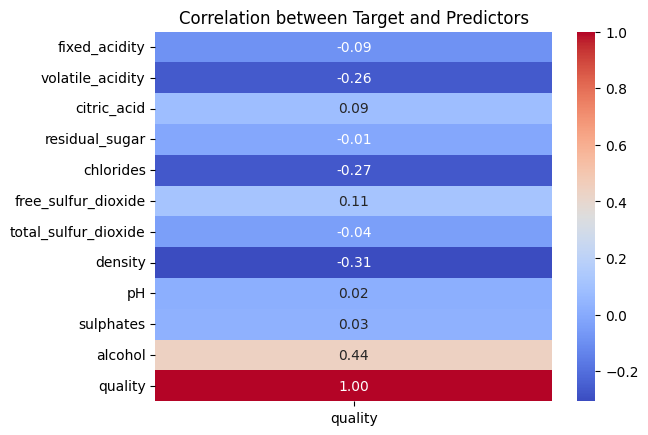

In [117]:
corr_matrix = pd.concat([X_transformed, y], axis=1)
sns.heatmap(corr_matrix.corr()[['quality']],
            annot=True,
            cmap='coolwarm',
            fmt='.2f'
)
plt.title('Correlation between Target and Predictors')
plt.show()

In [118]:
X_transformed

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,2.001480,-0.356675,0.00,0.641854,-2.577022,2.397895,34.0,-0.002202,3.51,-0.579818,2.240710
1,2.054124,-0.127833,0.00,0.955511,-2.322788,3.218876,67.0,-0.003205,3.20,-0.385662,2.282382
2,2.054124,-0.274437,0.04,0.832909,-2.385967,2.708050,54.0,-0.003005,3.26,-0.430783,2.282382
3,2.415914,-1.272966,0.56,0.641854,-2.590267,2.833213,60.0,-0.002002,3.16,-0.544727,2.282382
4,2.001480,-0.356675,0.00,0.641854,-2.577022,2.397895,34.0,-0.002202,3.51,-0.579818,2.240710
...,...,...,...,...,...,...,...,...,...,...,...
6492,1.824549,-1.560648,0.29,0.470004,-3.244194,3.178054,92.0,-0.008899,3.27,-0.693147,2.415914
6493,1.887070,-1.139434,0.36,2.079442,-3.057608,4.043051,168.0,-0.005113,3.15,-0.776529,2.261763
6494,1.871802,-1.427116,0.19,0.182322,-3.194183,3.401197,111.0,-0.007488,2.99,-0.776529,2.240710
6495,1.704748,-1.237874,0.30,0.095310,-3.816713,2.995732,110.0,-0.011374,3.34,-0.967584,2.549445


In [119]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y,
    test_size=0.33
)

print(f'Tamanho do conjunto de treino: {X_train.shape[0]} observações.')
print(f'Tamanho do conjunto de teste: {y_test.shape[0]} observações.')

Tamanho do conjunto de treino: 4352 observações.
Tamanho do conjunto de teste: 2145 observações.


In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.min(), X_train_scaled.max(), X_test_scaled.min(), X_test_scaled.max()

(np.float64(-4.619833886943173),
 np.float64(5.7686137297945494),
 np.float64(-4.619833886943173),
 np.float64(14.683328148323119))

In [121]:
scaler.scale_, scaler.mean_

(array([1.64859686e-01, 4.36171559e-01, 1.45256572e-01, 8.61834800e-01,
        4.32689374e-01, 6.97270132e-01, 5.66114547e+01, 2.96493997e-03,
        1.59607581e-01, 2.55848293e-01, 1.11430953e-01]),
 array([ 1.96420613e+00, -1.17970960e+00,  3.20261949e-01,  1.33158318e+00,
        -2.98867618e+00,  3.22127218e+00,  1.16024816e+02, -5.29572384e-03,
         3.21673024e+00, -6.66575852e-01,  2.34308950e+00]))

In [122]:
X_test_scaled.mean(), X_train_scaled.mean()

(np.float64(-0.010266857049854304), np.float64(2.3963303118413303e-16))

In [123]:
X_train_scaled1 = np.c_[np.ones_like(X_train_scaled[:, 0]), X_train_scaled]
X_test_scaled1 = np.c_[np.ones_like(X_test_scaled[:, 0]), X_test_scaled]

In [124]:
X_train_scaled.shape, X_test_scaled.shape, X_train_scaled1.shape, X_test_scaled1.shape

((4352, 11), (2145, 11), (4352, 12), (2145, 12))

# CUSTOM OLS

$$
\boldsymbol{\beta} = \left( X^\top X \right)^{-1} X^\top \mathbf{y}
$$

In [125]:
beta = np.linalg.inv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ y_train
beta

,quality
0,0.071728
1,-0.220441
2,0.000628
3,0.187793
4,-0.021441
5,0.181424
6,-0.197585
7,-0.118710
8,0.039033
9,0.112104


In [126]:
def custom_OLS(X_train, X_test, y_train, y_test):

  beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

  y_train_pred = X_train @ beta
  y_test_pred = X_test @ beta

  #Train Error
  RSS_train = np.sum((np.array(y_train_pred) - np.array(y_train))**2)
  MSE_train = RSS_train/y_train.shape[0]
  R2_train = 1 - np.sum((np.array(y_train) - np.array(y_train_pred)) ** 2) / np.sum((np.array(y_train) - np.array(y_train).mean()) ** 2)

  print(f'RSS_train = {RSS_train}')
  print(f'MSE_train = {MSE_train}')
  print(f'R2_train = {R2_train}\n\n')

  #Test Error
  RSS = np.sum((np.array(y_test_pred) - np.array(y_test))**2)
  MSE = RSS/y_test.shape[0]
  R2 = 1 - np.sum((np.array(y_test) - np.array(y_test_pred)) ** 2) / np.sum((np.array(y_test) - np.array(y_test).mean()) ** 2)

  print(f'RSS_test = {RSS:.3f}')
  print(f'MSE_test = {MSE:.3f}')
  print(f'R2_test = {R2:.3f}')

custom_OLS(X_train_scaled1, X_test_scaled1, y_train, y_test)


RSS_train = 2364.960033399524
MSE_train = 0.5434191253215818
R2_train = 0.29377341962453296


RSS_test = 1085.671
MSE_test = 0.506
R2_test = 0.323


In [127]:
model = LinearRegression().fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'MSE = {mse:.3f}')
print(f'R2 = {r2:.3f}')

MSE = 0.506
R2 = 0.323


# KFOLD CUSTOM

In [128]:
def custom_Kfold(k, X, Y, random_seed=42):

    X = np.array(X)
    Y = np.array(Y)

    n = len(X)
    
    np.random.seed(random_seed)
    indexes = np.random.permutation(n)
    X = X[indexes]
    Y = Y[indexes]

    fold_size = n//k
    folds = []

    for i in range(k):
        test_start = i * fold_size
        test_end = test_start + fold_size if i < k - 1 else n-2

        X_test = X[test_start:test_end]
        Y_test = Y[test_start:test_end]

        X_train = np.concatenate((X[:test_start], X[test_end:]), axis=0)
        Y_train = np.concatenate((Y[:test_start], Y[test_end:]), axis=0)

        folds.append([X_train, X_test, Y_train, Y_test])

    return folds

PARA OLS
$$
\boldsymbol{\beta} = \left( X^\top X  \right )^{-1} X^\top \mathbf{y}
$$

PARA RIDGE
$$
\boldsymbol{\beta} = \left( X^\top X - \boldsymbol{\lambda}I \right )^{-1} X^\top \mathbf{y}
$$



In [129]:
def custom_Kfold_CV(k, X_transformed, Y, print_kfold=False, regression = 'OLS', mode='custom', penalty=0, lambdas = np.arange(1, 1001, 1)):
    folds = custom_Kfold(k, X_transformed, Y)

    mse_train_list = []
    r2_train_list = []
    mse_test_list = []
    r2_test_list = []
    betas_list = []

    for i, (X_train, X_test, y_train, y_test) in enumerate(folds):

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)


        if mode == 'custom':
            X_train_scaled = np.c_[np.ones_like(X_train_scaled[:, 0]), X_train_scaled]
            X_test_scaled = np.c_[np.ones_like(X_test_scaled[:, 0]), X_test_scaled]
            beta = np.linalg.inv((X_train_scaled.T @ X_train_scaled + (penalty * np.identity(X_train_scaled.shape[1])))) @ X_train_scaled.T @ y_train
            betas_list.append(beta)

            y_train_pred = X_train_scaled @ beta
            y_test_pred = X_test_scaled @ beta

            #Train Error
            RSS_train = np.sum((np.array(y_train_pred) - np.array(y_train))**2)
            MSE_train = RSS_train/y_train.shape[0]
            R2_train = 1 - np.sum((np.array(y_train) - np.array(y_train_pred)) ** 2) / np.sum((np.array(y_train) - np.array(y_train).mean()) ** 2)

            mse_train_list.append(MSE_train)
            r2_train_list.append(R2_train)

            #Test Error
            RSS = np.sum((np.array(y_test_pred) - np.array(y_test))**2)
            MSE = RSS/y_test.shape[0]
            R2 = 1 - np.sum((np.array(y_test) - np.array(y_test_pred)) ** 2) / np.sum((np.array(y_test) - np.array(y_test).mean()) ** 2)

            mse_test_list.append(MSE)
            r2_test_list.append(R2)

            
        elif mode == 'built-in':
            if regression == 'OLS':
                model = LinearRegression().fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)

                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                # print(f'MSE = {mse:.3f}')
                # print(f'R2 = {r2:.3f}')
                
            elif regression == 'RIDGE':
                ridge = Ridge(alpha=penalty)
                ridge.fit(X_train_scaled, y_train)
                y_pred = ridge.predict(X_test_scaled)

                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                # print(f'MSE = {mse:.3f}')
                # print(f'R2 = {r2:.3f}')
            mse_test_list.append(mse)
            r2_test_list.append(r2)

    if print_kfold:
        df_results = pd.DataFrame({
        #     'MSE_train': mse_train_list,
        #     'R2_train': r2_train_list,
            'MSE_test': mse_test_list,
            'R2_test': r2_test_list
        })

        display(df_results.style.format({
        #     'MSE_train': '{:.3f}',
        #     'R2_train': '{:.3f}',
            'MSE_test': '{:.3f}',
            'R2_test': '{:.3f}'
        }))

    return np.min(mse_test_list), r2_test_list[np.argmin(mse_test_list)]


In [130]:
def builtin_Kfold_CV(k, X, Y, print_kfold=False, regression = 'OLS', mode='custom', penalty=0, lambdas = np.arange(1, 1001, 1)):

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    mse_test_list = []
    r2_test_list = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        if mode == 'custom':
            X_train_scaled = np.c_[np.ones_like(X_train_scaled[:, 0]), X_train_scaled]
            X_test_scaled = np.c_[np.ones_like(X_test_scaled[:, 0]), X_test_scaled]
            beta = np.linalg.inv((X_train_scaled.T @ X_train_scaled + (penalty * np.identity(X_train_scaled.shape[1])))) @ X_train_scaled.T @ y_train

            y_train_pred = X_train_scaled @ beta
            y_test_pred = X_test_scaled @ beta

            #Train Error
            RSS_train = np.sum((np.array(y_train_pred) - np.array(y_train))**2)
            MSE_train = RSS_train/y_train.shape[0]
            R2_train = 1 - np.sum((np.array(y_train) - np.array(y_train_pred)) ** 2) / np.sum((np.array(y_train) - np.array(y_train).mean()) ** 2)

            # mse_train_list.append(MSE_train)
            # r2_train_list.append(R2_train)

            #Test Error
            RSS = np.sum((np.array(y_test_pred) - np.array(y_test))**2)
            MSE = RSS/y_test.shape[0]
            R2 = 1 - np.sum((np.array(y_test) - np.array(y_test_pred)) ** 2) / np.sum((np.array(y_test) - np.array(y_test).mean()) ** 2)

            mse_test_list.append(MSE)
            r2_test_list.append(R2)

            
        elif mode == 'built-in':
            if regression == 'OLS':
                model = LinearRegression().fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                
            elif regression == 'RIDGE':
                ridge = Ridge(alpha=penalty)
                ridge.fit(X_train_scaled, y_train)
                y_pred = ridge.predict(X_test_scaled)

            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            # print(f'MSE = {mse:.3f}')
            # print(f'R2 = {r2:.3f}')
            mse_test_list.append(mse)
            r2_test_list.append(r2)

    if print_kfold:
        df_results = pd.DataFrame({
        #     'MSE_train': mse_train_list,
        #     'R2_train': r2_train_list,
            'MSE_test': mse_test_list,
            'R2_test': r2_test_list
        })

        display(df_results.style.format({
        #     'MSE_train': '{:.3f}',
        #     'R2_train': '{:.3f}',
            'MSE_test': '{:.3f}',
            'R2_test': '{:.3f}'
        }))


    return np.min(mse_test_list), r2_test_list[np.argmin(mse_test_list)]

### Custom OLS and K =5

In [141]:
custom_Kfold_CV(5, X_transformed, y, print_kfold=True ,regression='OLS', mode = 'custom'), builtin_Kfold_CV(5, X_transformed, y, print_kfold=True ,regression='OLS', mode = 'custom')

,MSE_test,R2_test
0,0.531,0.281
1,0.536,0.297
2,0.524,0.320
3,0.540,0.308
4,0.535,0.297


,MSE_test,R2_test
0,0.532,0.280
1,0.535,0.299
2,0.525,0.318
3,0.541,0.308
4,0.533,0.298


((np.float64(0.5243120549281488), np.float64(0.3197868418924781)),
 (np.float64(0.5247774134142962), np.float64(0.31782049198596596)))

### Built-in OLS and K = 5

In [143]:
custom_Kfold_CV(5, X_transformed, y, print_kfold=True ,regression='OLS', mode = 'built-in'), builtin_Kfold_CV(5, X_transformed, y, print_kfold=True ,regression='OLS', mode = 'built-in')

,MSE_test,R2_test
0,0.531,0.281
1,0.536,0.297
2,0.524,0.320
3,0.540,0.308
4,0.535,0.297


,MSE_test,R2_test
0,0.532,0.280
1,0.535,0.299
2,0.525,0.318
3,0.541,0.308
4,0.533,0.298


((np.float64(0.5243120549281486), 0.3197868418924784),
 (np.float64(0.5247774134142965), 0.3178204919859656))

### Custom OLS and K=10

In [142]:
custom_Kfold_CV(10, X_transformed, y, print_kfold=True ,regression='OLS', mode = 'custom'), builtin_Kfold_CV(10, X_transformed, y, print_kfold=True ,regression='OLS', mode = 'custom')

,MSE_test,R2_test
0,0.482,0.330
1,0.581,0.234
2,0.494,0.307
3,0.575,0.290
4,0.529,0.335
5,0.525,0.298
6,0.570,0.308
7,0.509,0.309
8,0.604,0.251
9,0.460,0.354


,MSE_test,R2_test
0,0.481,0.330
1,0.584,0.231
2,0.490,0.309
3,0.578,0.289
4,0.526,0.343
5,0.524,0.290
6,0.576,0.306
7,0.504,0.312
8,0.602,0.255
9,0.461,0.351


((np.float64(0.4602288485420704), np.float64(0.3539149913415841)),
 (np.float64(0.46124820795565424), np.float64(0.35074388287639835)))

### Built-in OLS and K=10

In [144]:
custom_Kfold_CV(10, X_transformed, y, print_kfold=True ,regression='OLS', mode = 'built-in'), builtin_Kfold_CV(10, X_transformed, y, print_kfold=True ,regression='OLS', mode = 'built-in')

,MSE_test,R2_test
0,0.482,0.330
1,0.581,0.234
2,0.494,0.307
3,0.575,0.290
4,0.529,0.335
5,0.525,0.298
6,0.570,0.308
7,0.509,0.309
8,0.604,0.251
9,0.460,0.354


,MSE_test,R2_test
0,0.481,0.330
1,0.584,0.231
2,0.490,0.309
3,0.578,0.289
4,0.526,0.343
5,0.524,0.290
6,0.576,0.306
7,0.504,0.312
8,0.602,0.255
9,0.461,0.351


((np.float64(0.4602288485420702), 0.35391499134158433),
 (np.float64(0.46124820795565497), 0.35074388287639735))

### Custom Ridge and Custom KFold-CV

5-fold
r2 = 0.320
mse = 0.524
best penalty with custom ridge and custom KfoldCV = 1


10-fold
r2 = 0.355
mse = 0.460
best penalty with custom ridge and custom KfoldCV = 26




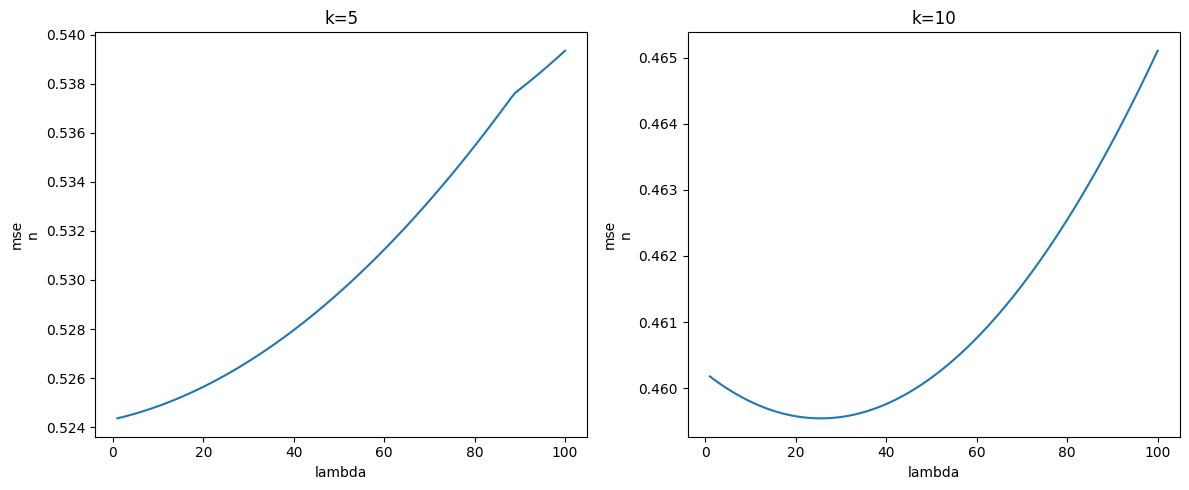

In [145]:
lambdas = np.arange(1, 101, 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.flatten()

for i, k in enumerate([5,10]):
  r2_lambda = []
  mse_lambda = []
  for alpha in lambdas:
    mse, r2 = custom_Kfold_CV(k=k, X_transformed=X_transformed, Y=y, regression = 'RIDGE', mode='custom', penalty=alpha, lambdas = lambdas)
    r2_lambda.append(r2)
    mse_lambda.append(mse)
  print(f"{k}-fold")
  print(f"r2 = {r2_lambda[np.argmin(mse_lambda)]:.3f}")
  print(f"mse = {np.min(mse_lambda):.3f}")

  best_penalty = lambdas[np.argmin(mse_lambda)]
  print(f"best penalty with custom ridge and custom KfoldCV = {best_penalty}\n\n")
  ax[i].plot(lambdas, mse_lambda)
  ax[i].set_xlabel("lambda")
  ax[i].set_ylabel("mse\nn")
  ax[i].set_title(f'{k=}')

plt.tight_layout()

### Built-in Ridge and Custom KFold-CV

5-fold
r2 = 0.320
mse = 0.524
best penalty with built-in ridge and custom KfoldCV = 1


10-fold
r2 = 0.354
mse = 0.460
best penalty with built-in ridge and custom KfoldCV = 48




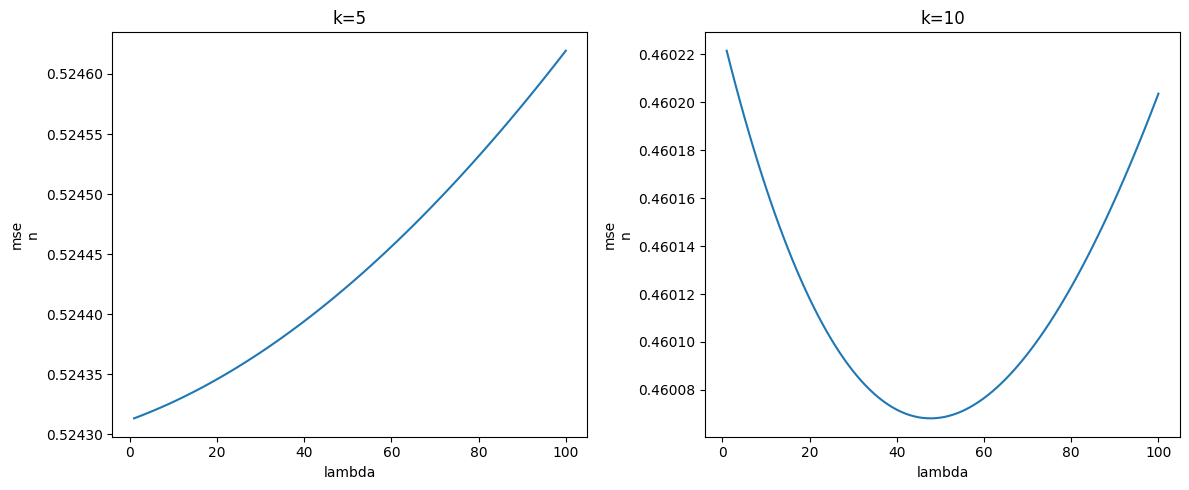

In [137]:
lambdas = np.arange(1, 101, 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.flatten()

for i, k in enumerate([5,10]):
  r2_lambda = []
  mse_lambda = []
  for alpha in lambdas:
    mse, r2 = custom_Kfold_CV(k=k, X_transformed=X_transformed, Y=y, regression = 'RIDGE', mode='built-in', penalty=alpha, lambdas = lambdas)
    r2_lambda.append(r2)
    mse_lambda.append(mse)
  print(f"{k}-fold")
  print(f"r2 = {r2_lambda[np.argmin(mse_lambda)]:.3f}")
  print(f"mse = {np.min(mse_lambda):.3f}")

  best_penalty = lambdas[np.argmin(mse_lambda)]
  print(f"best penalty with built-in ridge and custom KfoldCV = {best_penalty}\n\n")
  ax[i].plot(lambdas, mse_lambda)
  ax[i].set_xlabel("lambda")
  ax[i].set_ylabel("mse\nn")
  ax[i].set_title(f'{k=}')

plt.tight_layout()

### Custom Ridge and Built-in KFold-CV

5-fold
r2 = 0.318
mse = 0.525
best penalty with custom ridge and builtin KfoldCV = 1


10-fold
r2 = 0.352
mse = 0.461
best penalty with custom ridge and builtin KfoldCV = 26




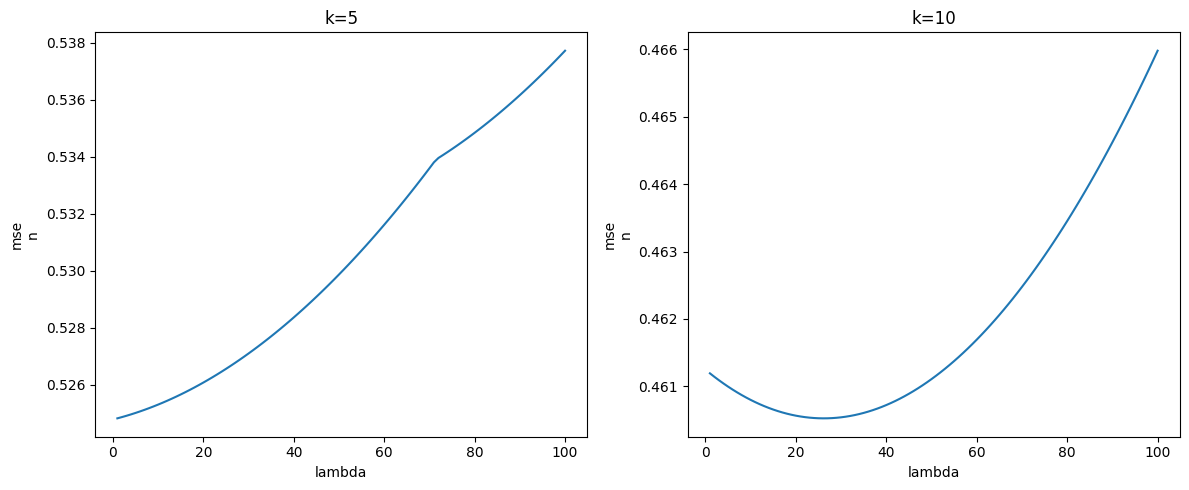

In [138]:
lambdas = np.arange(1, 101, 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.flatten()

for i, k in enumerate([5,10]):
  r2_lambda = []
  mse_lambda = []
  for alpha in lambdas:
    mse, r2 = builtin_Kfold_CV(k=k, X=X_transformed, Y=y, regression = 'RIDGE', mode='custom', penalty=alpha, lambdas = lambdas)
    r2_lambda.append(r2)
    mse_lambda.append(mse)
  print(f"{k}-fold")
  print(f"r2 = {r2_lambda[np.argmin(mse_lambda)]:.3f}")
  print(f"mse = {np.min(mse_lambda):.3f}")

  best_penalty = lambdas[np.argmin(mse_lambda)]
  print(f"best penalty with custom ridge and builtin KfoldCV = {best_penalty}\n\n")
  ax[i].plot(lambdas, mse_lambda)
  ax[i].set_xlabel("lambda")
  ax[i].set_ylabel("mse\nn")
  ax[i].set_title(f'{k=}')

plt.tight_layout()

### Built-in Ridge and Built-in KFold-CV

5-fold
r2 = 0.318
mse = 0.525
best penalty with custom ridge and builtin KfoldCV = 1


10-fold
r2 = 0.351
mse = 0.461
best penalty with custom ridge and builtin KfoldCV = 56




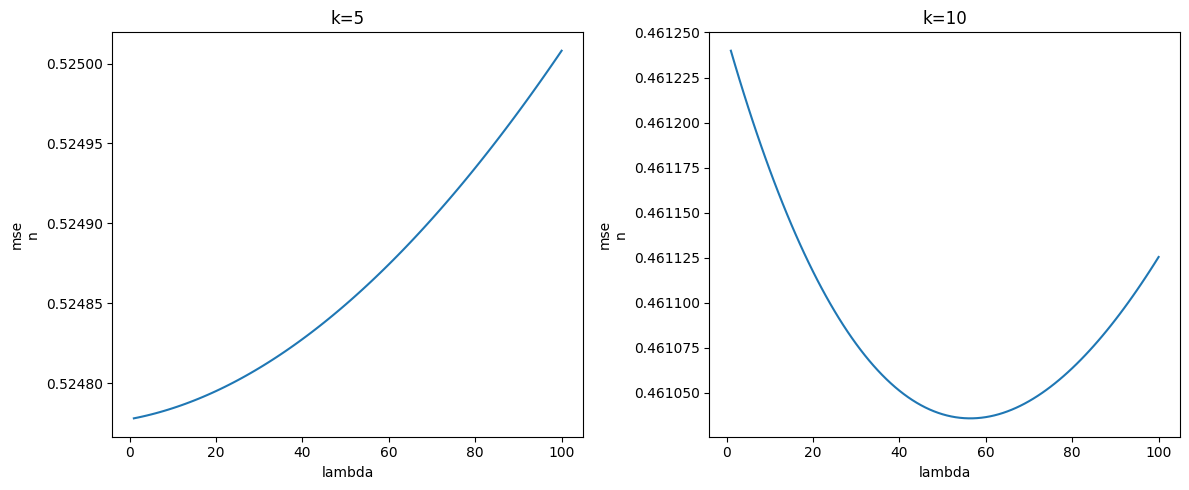

In [139]:
lambdas = np.arange(1, 101, 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.flatten()

for i, k in enumerate([5,10]):
  r2_lambda = []
  mse_lambda = []
  for alpha in lambdas:
    mse, r2 = builtin_Kfold_CV(k=k, X=X_transformed, Y=y, regression = 'RIDGE', mode='built-in', penalty=alpha, lambdas = lambdas)
    r2_lambda.append(r2)
    mse_lambda.append(mse)
  print(f"{k}-fold")
  print(f"r2 = {r2_lambda[np.argmin(mse_lambda)]:.3f}")
  print(f"mse = {np.min(mse_lambda):.3f}")

  best_penalty = lambdas[np.argmin(mse_lambda)]
  print(f"best penalty with custom ridge and builtin KfoldCV = {best_penalty}\n\n")
  ax[i].plot(lambdas, mse_lambda)
  ax[i].set_xlabel("lambda")
  ax[i].set_ylabel("mse\nn")
  ax[i].set_title(f'{k=}')

plt.tight_layout()